In [1]:
import vaex
import pandas as pd
import numpy as np

In [ ]:
n_rows = 1000000
n_cols = 1000

In [ ]:
df = pd.DataFrame(np.random.randint(0, 100, size=(n_rows, n_cols)), columns=['col%d' % i for i in range(n_cols)])
df.head()

In [2]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Columns: 1000 entries, col0 to col999
dtypes: int64(1000)
memory usage: 7.5 GB


In [3]:
file_path = 'big_file.csv'
df.to_csv(file_path, index=False)

我们需要将CSV转换为HDF5，才能看到Vaex的优点。

In [ ]:
dv = vaex.from_csv(file_path, convert=True, chunk_size=5_000_000)

In [2]:
dv = vaex.open('big_file.csv.hdf5')

In [3]:
suma = dv.col1.sum()
suma
# array(49486599)

array(49500520)

In [4]:
dv['col1_plus_col2'] = dv.col1 + dv.col2
dv['col1_plus_col2']

Expression = col1_plus_col2
Length: 1,000,000 dtype: int64 (column)
---------------------------------------
     0   86
     1  147
     2  125
     3  133
     4  124
    ...    
999995  150
999996   50
999997   97
999998  111
999999  104

有了Vaex，你可以通过一个操作来完成，并且只需要一次数据传递！下面的group-by示例超过11亿行，只需要30秒。

In [6]:
dv.groupby(by='vendor_id', agg={'count': vaex.agg.count(),
                                'count_fare_n_pass_lt3': vaex.agg.count(selection='passenger_count<3'),
                                'count_fare_n_pass_ge3': vaex.agg.count(selection='passenger_count>=3'),
                                'mean_fare_n_pass_lt3': vaex.agg.mean('fare_amount', selection='passenger_count<3'),
                                'mean_fare_n_pass_ge3': vaex.agg.mean('fare_amount', selection='passenger_count>=3'),
                               })


NameError: Column or variable 'vendor_id' does not exist.

只要虚拟列只使用Numpy或纯Python操作定义，Vaex就可以通过jitting加速它的计算，或者通过Numba或Pythran进行即时编译。如果你的机器有支持CUDA的NVIDIA显卡，Vaex 也支持通过CUDA加速。这对于加速计算开销很大的虚列的计算非常有用。

In [7]:
def arc_distance(theta_1, phi_1, theta_2, phi_2):
    temp = (np.sin((theta_2-theta_1)/2*np.pi/180)**2
           + np.cos(theta_1*np.pi/180)*np.cos(theta_2*np.pi/180) * np.sin((phi_2-phi_1)/2*np.pi/180)**2)
    distance = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1-temp))
    return distance * 3958.8

df['arc_distance_numpy'] = arc_distance(df.pickup_longitude, 
                                        df.pickup_latitude, 
                                        df.dropoff_longitude, 
                                        df.dropoff_latitude)

df['arc_distance_numba'] = arc_distance(df.pickup_longitude, 
                                        df.pickup_latitude, 
                                        df.dropoff_longitude, 
                                        df.dropoff_latitude).jit_numba()
 
mean_numpy = df.arc_distance_numpy.mean(progress='widget')
mean_numba = df.arc_distance_numba.mean(progress='widget')
print(f'Mean arc distance comuted with numpy: {mean_numpy:.5f}')
print(f'Mean arc distance comuted with numba: {mean_numba:.5f}')


NameError: name 'df' is not defined

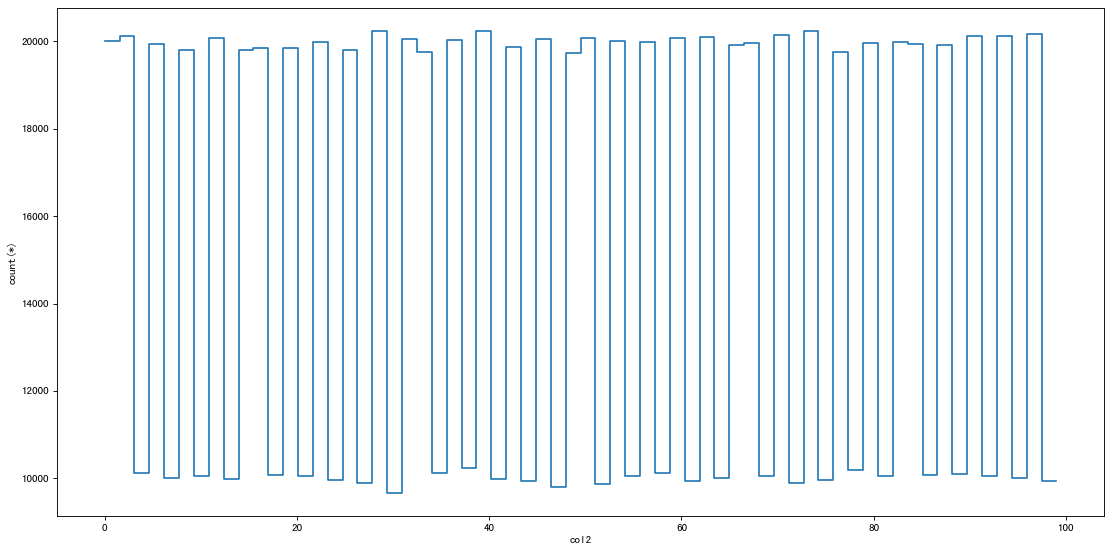

In [8]:
dv.plot1d(dv.col2, figsize=(14, 7))

In [10]:
binned_dist_npass_lt3, binned_dist_npass_ge3 = dv.count(binby=['total_amount'],
                                                        limits=[5, 50],
                                                        shape=64,
                                                        selection=[select_n_passengers_lt3, 
                                                                   select_n_passengers_ge3], 
                                                        progress='widget')

xvalues = np.linspace(5, 50, 64)
plt.figure(figsize=(8, 4))
plt.plot(xvalues, binned_dist_npass_lt3, drawstyle="steps-pre", label='num passengers < 3', lw=3)
plt.plot(xvalues, binned_dist_npass_ge3, drawstyle="steps-pre", label='num passengers >=3', lw=3)
plt.legend(fontsize=14)
plt.xlabel('Total amount [$]', fontsize=14)
plt.ylabel('Number of trips', fontsize=14)
plt.show()

NameError: name 'select_n_passengers_lt3' is not defined

In [11]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook